# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = "traffic-signs-data/train.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_input, y_train_input = train['features'], train['labels']
X_train_sizes, X_train_coords = train['sizes'], train['coords']
X_test_input, y_test = test['features'], test['labels']
X_test_sizes, X_test_coords = test['sizes'], test['coords']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
# Summarize dataset
n_train = len(X_train_input)
n_test = len(X_test_input)
image_shape = X_train_input[0].shape
n_classes = len(set(y_train_input))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

In [4]:
# Global variable for settings and tuning
DEBUG = 1
VALIDATION_RATIO = 0.2

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

1. Converted input data to grayscale
    - Traffic signs carry significant information in shape and text hence color could be considered secondary. Color images could be considered to train the network if the accuracy is not acceptable. Current performance is acceptable. Color images could be considered for future work
2. Normalized input data:
    - This ensures the weights are evenly distrbuted.
    - Normalizing also ensures that weights do not get saturated easily while training
3. Reshape input data to format accepted by network:
    - LeNet input layer accepts tensors of 4 dimensions. Input images are reshaped to a format acceptable by tensorflow
4. Use bounding box to define the region of interest and cut out only those parts contained by the bounding box
    - Out of the entire image, significant information is carried by bounding box specified in the database. Rest of the image content is noise for the network. Extracting this bounding box from input image trains network with meaningful data and improves accuracy.
5. Analyzed the data to check if the input data is biased towards a particular label(i.e. more data for label x compared to average images per label)
    - If data is biased, add more synthetic data by rotating and translating input data
    - This step balances data and avoids bias towards labels with more number of images
    - Current implementation calculates the mean of all images and generates augmented images for labels with lesser number of images such that the count for such labels is around the mean value

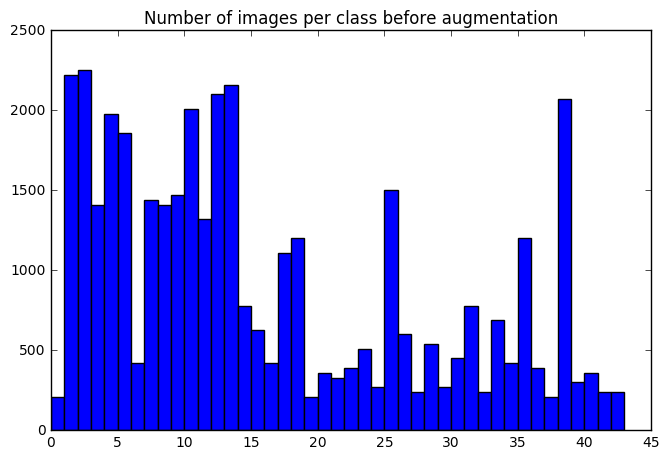

In [5]:
# Analyze and preprocess data.

import cv2
import numpy as np
        
def get_reshaped_image(img):
    img = cv2.resize(img, (32, 32))
    return np.reshape(img, (32, 32, 1))

def grayscale(img):
    return cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

def normalize(arr):
    arr=arr.astype('float32')
    if arr.max() > 1.0:
        arr/=255.0
    return arr

def extract_bounding_box(img, i):
    # Extract out data represented by the bounding box
    w, h = X_train_sizes[i][0], X_train_sizes[i][1]
    x1, y1, x2, y2 = X_train_coords[i][0], X_train_coords[i][1], X_train_coords[i][2], X_train_coords[i][3]
    w1, h1 = image_shape[0], image_shape[1]
    x1 = int(x1 * 1.0 * w1/w)
    x2 = int(x2 * 1.0 * w1/w)
    y1 = int(y1 * 1.0 * h1/h)
    y2 = int(y2 * 1.0 * h1/h)
    img = img[y1:y2, x1:x2]
    img = cv2.resize(img, (w1, h1))
    return img

import random
SEED = 344839
AUGMENT_ANGLE_RANGE = 3
AUGMENT_TRANSLATE_RANGE = 3

def augment_data(images, labels, counts):
    out_images = []
    out_labels = []
    for i, image in enumerate(images):
        #print("Augment count = ", str(count))
        out_images.append(get_reshaped_image(image))
        out_labels.append(labels[i])
        random.seed(SEED)
        
        for j in range(counts[labels[i]]):
            factor = random.randint(-1 * AUGMENT_ANGLE_RANGE, AUGMENT_ANGLE_RANGE)

            # Rotate
            M = cv2.getRotationMatrix2D((image_shape[0]/2, image_shape[1]/2), factor,1)
            dst = cv2.warpAffine(image,M,(image_shape[0],image_shape[1]))

            factor1 = random.randint(-1 * AUGMENT_TRANSLATE_RANGE, AUGMENT_TRANSLATE_RANGE)
            factor2 = random.randint(-1 * AUGMENT_TRANSLATE_RANGE, AUGMENT_TRANSLATE_RANGE)
            # Shift
            M = np.float32([[1,0,factor1],[0,1,factor2]])
            dst = cv2.warpAffine(dst,M,(image_shape[0],image_shape[1]))

            out_images.append(get_reshaped_image(dst))
            out_labels.append(labels[i])
    return out_images, out_labels

def analyse_data(labels, caption):
    counts = []
    labels = list(labels)
    
    for idx, label in enumerate(set(labels)):
        counts.append(labels.count(label))
    
    # Plot a graph to analyse data and decide how to augment
    fig = plt.figure()
    ax1 = fig.add_axes([0,0,1., 1.])
    ax1.bar(range(0, n_classes), counts, 1)
    ax1.set_title('Number of images per class' + ' ' + caption)
    plt.show()
  
    #max_class_images =np.mean(counts)
    max_class_images =np.max(counts)
    augment_counts = [int(max_class_images/count - 1) for count in counts]
    #print(set(labels), counts, diff_counts)
    return augment_counts

aug_counts = analyse_data(y_train_input, "before augmentation")

def preprocess_list(X_list, X_sizes, X_coords, hasCoords=False):
    X_new = []
    for i, X in enumerate(X_list):
        X = grayscale(X)
        X = normalize(X)
        if hasCoords:
            X = extract_bounding_box(X, i)
        X = get_reshaped_image(X)
        X_new.append(X)
    return X_new

X_train_pp = preprocess_list(X_train_input, X_train_sizes, X_train_coords, hasCoords=True)
X_test_pp = preprocess_list(X_test_input, X_test_sizes, X_test_coords, hasCoords=True)

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

Current implementation uses LeNet network to classify input images into one out of the 43 classes

<b>Training and validation set generation</b>
   1. Preprocess data as mentioned above
   2. Use training data and split into training and validation set using a ratio (for current implementation 0.2)
   3. Define a batch size (current implementation 128) to operate on data depending on the memory available on GPU
   
<b>Testing set generation</b>
   1. Load data from pickle file
 
<b>External test set generation</b>
   1. Gather traffic signal images online and to evaluate performance of the network
   2. Crop traffic signs such that significant part of the image is traffic sign. In a real world scenario, object detection algorithm would detect these bounding boxes and feed them to the network
   3. Gather corresponding truth value and name the files with those truth values
   
<b><u>Generating additional data</u></b>

As noticed in the visualization above (Image caption 'Number of images per class') it can be seen that image data is not evenly distributed. Few labels have lesser samples available whereas some others have high amount of samples available.

Uneven distribution of data could lead to biased behavior of network and traffic signs with less number of signs are less likely to be detected correctly. To overcome this situation images for the classes with less number of samples have been augmented by generating synthetic data from available images. New images are generated by rotating and shifting input data by small random amounts to generate variety of evenly distributed input data.   

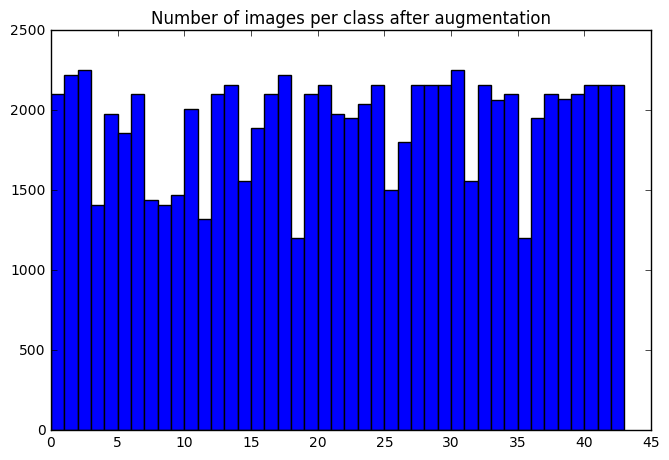

Augmentation count per label entry: [9, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 1, 2, 4, 1, 0, 9, 5, 5, 4, 3, 7, 0, 2, 8, 3, 7, 4, 1, 8, 2, 4, 0, 4, 9, 0, 6, 5, 8, 8]


In [6]:
#Additional data generated using augmentation
#1. Rotate the images by a random angle (limited to 3 degree rotation)
#2. Translate images (shifting in x, y or both axes, limited to 3 pixels in both the axes)

X_train_aug, y_train_aug = augment_data(X_train_pp, y_train_input, aug_counts)
analyse_data(y_train_aug, "after augmentation")
print("Augmentation count per label entry: " + str(aug_counts))

In [7]:
# Split data into training/validation sets. Testing data is already available in pickle data
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

X_train_in, y_train_in = shuffle(X_train_aug, y_train_aug)

X_train, X_validation, y_train, y_validation = train_test_split(X_train_in, y_train_in, test_size=VALIDATION_RATIO, random_state=SEED)

# Update image shape parameters (since we are operating on b/w images)
image_shape = X_train[0].shape

print("Data split: ")
print("------------")
print("   Training set   = %d images"%(len(X_train)))
print("   Validation set = %d images"%(len(X_validation)))
print("   Test set       = %d images"%(len(X_test_input)))

Data split: 
------------
   Training set   = 66405 images
   Validation set = 16602 images
   Test set       = 12630 images


In [8]:
# Plot Reference labels and corresponding images
DEBUG = 0
def display(img, label):
    plt.figure()
    plt.imshow(img)
    plt.suptitle("%s" % (label))
    plt.tight_layout()
    plt.axis('off')
    plt.show()

def display_many(images, labels):
    title_font = {'size':'40'}
    columns = 5
    rows = len(images)/columns
    plt.figure(figsize=(64, 64))
    for idx, img in enumerate(images):
        axis = plt.subplot(rows + 1, columns, idx+1)
        axis.xaxis.set_visible(False)
        axis.yaxis.set_visible(False)
        img = np.reshape(img, (image_shape[0], image_shape[1]))
        plt.imshow(img, cmap='gray')
        plt.title("[%d] %s" %(idx, labels[idx]), **title_font)
    plt.tight_layout()
    plt.show()
# Load label data from csv file
import csv
with open('signnames.csv', 'r') as csvfile:
    labelreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    
    sample_labels = []
    for idx, row in enumerate(labelreader):
        if(idx == 0):
            continue
        sample_labels.append(row[1])
        print (idx, row[1])

# Gather one image per class
sample_images = []
y_list = list(y_train)
for idx, label in enumerate(set(y_list)):
    id_label = y_list.index(label)
    sample_images.append(X_train[id_label])

if DEBUG:
    display_many(sample_images, sample_labels)

1 Speed limit (20km/h)
2 Speed limit (30km/h)
3 Speed limit (50km/h)
4 Speed limit (60km/h)
5 Speed limit (70km/h)
6 Speed limit (80km/h)
7 End of speed limit (80km/h)
8 Speed limit (100km/h)
9 Speed limit (120km/h)
10 No passing
11 No passing for vehicles over 3.5 metric tons
12 Right-of-way at the next intersection
13 Priority road
14 Yield
15 Stop
16 No vehicles
17 Vehicles over 3.5 metric tons prohibited
18 No entry
19 General caution
20 Dangerous curve to the left
21 Dangerous curve to the right
22 Double curve
23 Bumpy road
24 Slippery road
25 Road narrows on the right
26 Road work
27 Traffic signals
28 Pedestrians
29 Children crossing
30 Bicycles crossing
31 Beware of ice/snow
32 Wild animals crossing
33 End of all speed and passing limits
34 Turn right ahead
35 Turn left ahead
36 Ahead only
37 Go straight or right
38 Go straight or left
39 Keep right
40 Keep left
41 Roundabout mandatory
42 End of no passing
43 End of no passing by vehicles over 3.5 metric tons


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
#### Network Architecture:

<b><u>Model:</u></b>

Current implementation uses LeNet network with following layers and connections

<u><b>Layers and their details:</b></u>
1. Convolution (5 x 5, 32 kernels, stride 1)
- RELU
- Pool (Max pooling with 2 x 2 kernels and stride of 2)
- Convolution (5 x 5, 16 kernels, stride 1)
- RELU
- Pool (Max pooling with 2 x 2 kernels and stride of 2)
- FC (400 neurons input 120 neurons output)
- RELU
- FC (120 neurons input 84 neurons output)
- RELU
- FC (84 neurons input number of classes as output size)

<u><b>Input and Output:</b></u>

Two placeholders have been defined to 
1. Accept input data
2. Communicate the output data

In [9]:
# Network definition
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # SOLUTION: Activation.
    conv1 = tf.nn.relu(conv1)

    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # SOLUTION: Activation.
    conv2 = tf.nn.relu(conv2)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # SOLUTION: Activation.
    fc1    = tf.nn.relu(fc1)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # SOLUTION: Activation.
    fc2    = tf.nn.relu(fc2)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = class_count.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

In [10]:
# Define input and output placeholders to interface with tensorflow
import tensorflow as tf

x = tf.placeholder(tf.float32, (None, image_shape[0], image_shape[1], image_shape[2]))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

While training the network, validation loss and training batch loss were considered before updating the hyperparameters

<b> Optimizer: AdamOptimizer </b>
 - AdamOptimizer is amoung the best available optimizers to train the network in terms of convergence, stability and ease of use
 
<b> Training batch size: 128 </b>
- Since a GPU was available for training, even higher batch size would be possible to accomodate. Found batch size of 128 fit to operate without significantly affecting other processing relying on GPU

<b>Epochs executed: variable </b>
- Training stops when the validation accuracy goes above 99.5%
- An option is available to train on restored weights (when available) loaded from previously stored execution. The saved weights should be deleted while experimenting with differet architectures.
- Since the learning rate is good enough, restoring the model only serves to have a good starting point. With this approach, validation accuracy near 99% could be achieved without overfitting on input database. Performance on test data was observed to be good after using restored weights.

<b> INTENTIONALLY NOT USING RESTORED WEIGHTS TO DEMONSTRATE top_k PREDICTION SIGNIFICANCE </b> 

<b>Learning rate: 0.001 </b>
- Experimented with learning rates ranging from 0.1 to 0.00001 and found the network to perform well at 0.001

- Here grayscale images were used to train the network but color images could be used too

<b> Validation and visualization </b>
 - Apart from the steps mentioned above, visualizations were performed on the data found to be estimated wrong. All the validation samples for which outputs were incorrect were plotted and analyzed to get an idea of what the network is lacking to understand and which parameter to tune accordingly.

In [11]:
# Define optimizer parameters
rate = 0.001

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [12]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def get_labels_from_probabilities(probabilities):
    predicted_labels = []
    for probability_list in probabilities:
        probability_list = list(probability_list)
        predicted_labels.append(probability_list.index(max(probability_list)))
    return predicted_labels

def display_comparison(img1, img2, label1, label2):
    img1 = np.reshape(img1, (image_shape[0], image_shape[1]))
    img2 = np.reshape(img2, (image_shape[0], image_shape[1]))
    plt.figure()

    axis = plt.subplot(1, 2, 1)
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    axis.title.set_text(label1)
    plt.imshow(img1, cmap='gray')

    axis = plt.subplot(1, 2, 2)
    axis.xaxis.set_visible(False)
    axis.yaxis.set_visible(False)
    axis.title.set_text(label2)
    plt.imshow(img2, cmap='gray')
    
    plt.tight_layout()
    plt.show()

DISPLAY_LIMIT = 5
current_display_count = 0
def display_incorrect_predictions(predictions, x, y):
    global current_display_count
    if(current_display_count == 0):
        print("First " + str(DISPLAY_LIMIT) + " incorrect predictions")
    p_labels = get_labels_from_probabilities(predictions)
    for i in range(len(y)):
        if(current_display_count >= DISPLAY_LIMIT):
            break
        if(p_labels[i] != y[i]):
            label1 = "i: " + str(i) + " Input : " + sample_labels[y[i]] + "                  " 
            label2 = "Predicted:" + sample_labels[p_labels[i]]
            current_display_count += 1
            display_comparison(x[i], sample_images[p_labels[i]], label1, label2)

def evaluate(X_data, y_data, display_incorrect=False):
    num_examples = len(X_data)
    total_accuracy = 0

    sess = tf.get_default_session()
    global current_display_count
    current_display_count = 0
    predictions = []
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        scores = sess.run(logits, feed_dict={x: batch_x, y: batch_y})
        predictions.append(sess.run(tf.nn.softmax(scores)))
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
        if display_incorrect and current_display_count < DISPLAY_LIMIT:
            display_incorrect_predictions(predictions[-1], batch_x, batch_y)
    return total_accuracy / num_examples, predictions

def predict(X_data):
    num_examples = len(X_data)
    total_accuracy = 0

    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x = X_data[offset:offset+BATCH_SIZE]
        scores = sess.run(logits, feed_dict={x: batch_x})
        probabilities = sess.run(tf.nn.softmax(scores))
        p_labels = get_labels_from_probabilities(probabilities)
    return p_labels, probabilities

In [13]:
# Training the network
EPOCHS = 125
BATCH_SIZE = 128
ENABLE_LOADING = False

def load_saved_model(sess):
    files = os.listdir('.')
    found = False
    for file in files:
        if file == 'checkpoint':
            found = True
    if found:
        print ("Checkpoint located, restoring model")
        saver.restore(sess, tf.train.latest_checkpoint('.'))
    else:
        print("Could not locate checkpoint file. Creating a new model")

import os
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    if ENABLE_LOADING == True:
        load_saved_model(sess)
        
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy, predictions = evaluate(X_validation, y_validation)
        print('EPOCH %d/%d '%(i+1, EPOCHS) +
              'Validation Accuracy = %.5f '%validation_accuracy)
        #test_accuracy, test_predictions = evaluate(X_test_pp, y_test, display_incorrect=False)
        #print('Test Accuracy = %.5f'%test_accuracy)
        if (validation_accuracy > 0.995): #0.995
            break
        
    saver.save(sess, 'project2-net')
    print("\nModel saved")

Training...

EPOCH 1/125 Validation Accuracy = 0.87791 
EPOCH 2/125 Validation Accuracy = 0.93591 
EPOCH 3/125 Validation Accuracy = 0.95778 
EPOCH 4/125 Validation Accuracy = 0.96892 
EPOCH 5/125 Validation Accuracy = 0.97416 
EPOCH 6/125 Validation Accuracy = 0.97838 
EPOCH 7/125 Validation Accuracy = 0.98301 
EPOCH 8/125 Validation Accuracy = 0.98368 
EPOCH 9/125 Validation Accuracy = 0.98735 
EPOCH 10/125 Validation Accuracy = 0.98753 
EPOCH 11/125 Validation Accuracy = 0.98350 
EPOCH 12/125 Validation Accuracy = 0.98813 
EPOCH 13/125 Validation Accuracy = 0.98765 
EPOCH 14/125 Validation Accuracy = 0.98344 
EPOCH 15/125 Validation Accuracy = 0.99289 
EPOCH 16/125 Validation Accuracy = 0.99109 
EPOCH 17/125 Validation Accuracy = 0.98741 
EPOCH 18/125 Validation Accuracy = 0.98994 
EPOCH 19/125 Validation Accuracy = 0.99072 
EPOCH 20/125 Validation Accuracy = 0.99343 
EPOCH 21/125 Validation Accuracy = 0.99289 
EPOCH 22/125 Validation Accuracy = 0.99404 
EPOCH 23/125 Validation Accu

First 5 incorrect predictions


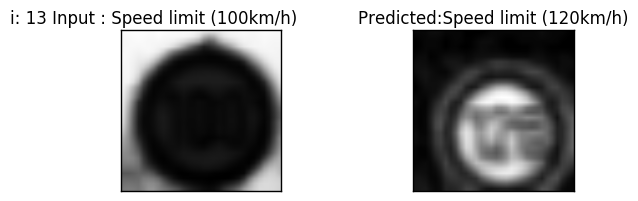

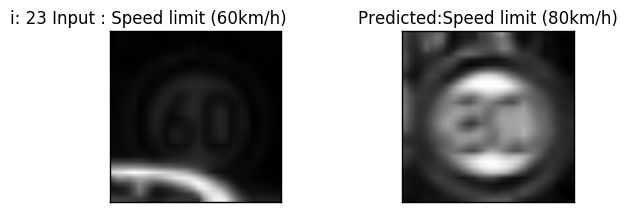

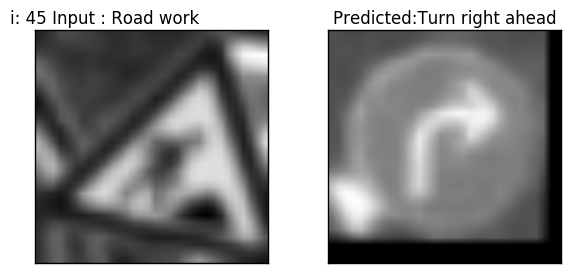

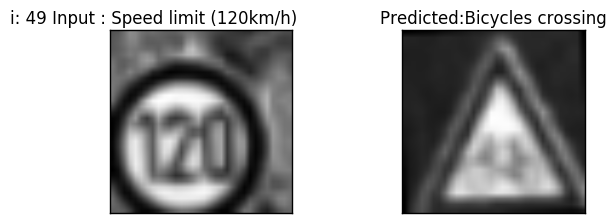

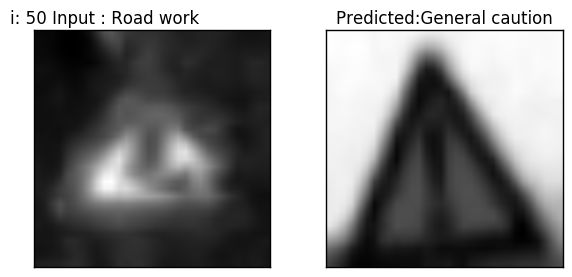


Test Accuracy = 89.786%


In [14]:
DEBUG = 1
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    compare_incorrect = False
    if DEBUG:
        compare_incorrect = True
    test_accuracy, test_prob = evaluate(X_test_pp, y_test, display_incorrect=compare_incorrect)
    print("\nTest Accuracy = {:.3f}%".format(test_accuracy*100.0))

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
- This is a multi class classification problem. The solution demanded classification of 43 classes using 32 x 32 images. 
- LeNet, AlexNet would have been better choices to operate on low resolution images with lesser samples
- Started with LeNet with an aim to understand and modify later if the performance does not meet requirements
- Other options available: ResNet, GoogLeNet (Usually used on high resolution images)

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

** Answer **

The network was run through three sets of images
1. Test images from database
    - With these images the accuracy of network was 89.7%. On analysis of images the inferences are visually similar to the input data. Few images are tilted and few are not well lit. The behavior is not far off visually.

2. Images taken from internet http://www.gettingaroundgermany.info/zeichen.shtml#reg resembling data from training set
    - The network estimates labels of these images with 100% accuracy. This is possibly because input images taken from internet have a better resolution, alignment and lesser noise compared to the ones in database. This implies that the network is generalizing the traffic signs well enough

3. Images taken form the internet where traffic signs did not belong to classes the network was trained for
    - We do not have labels for these images in the training dataset. Evaluation was conducted to check how network sees these signs and was a fun experiment

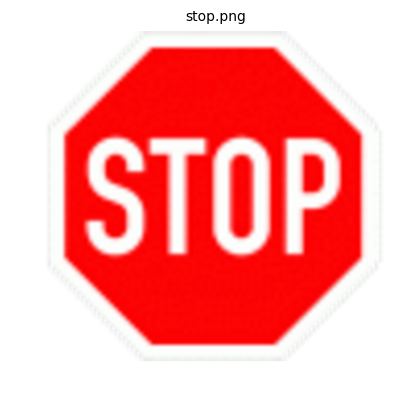

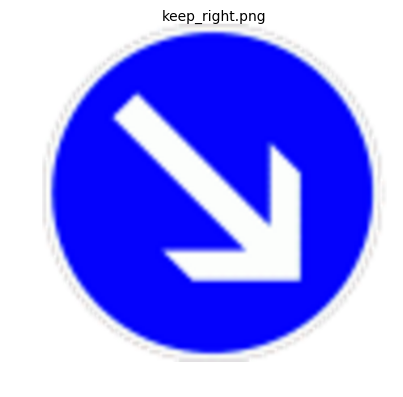

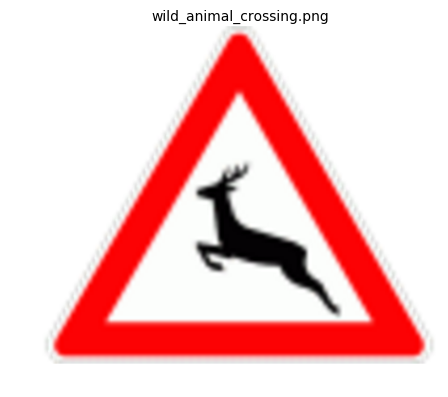

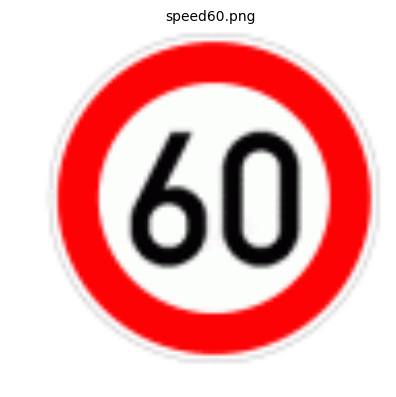

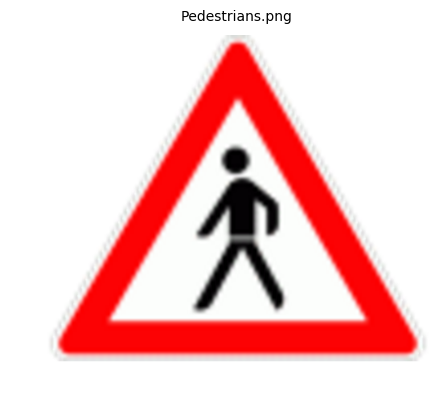

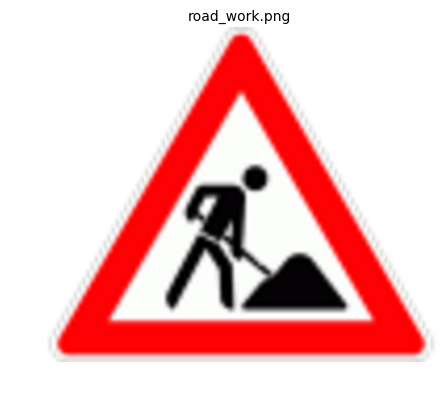

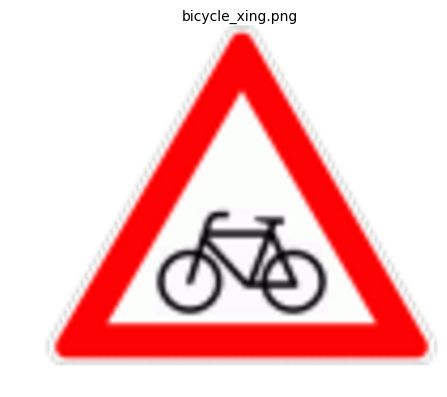

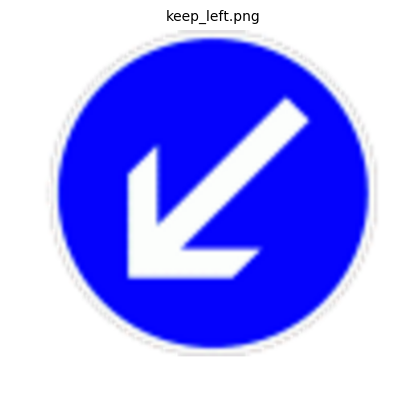

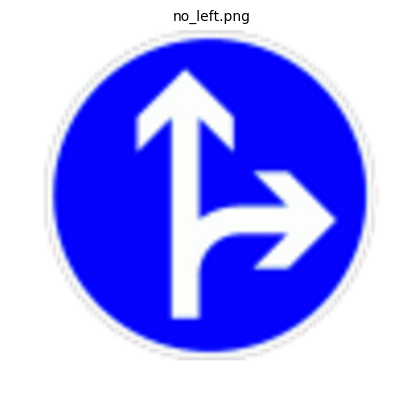

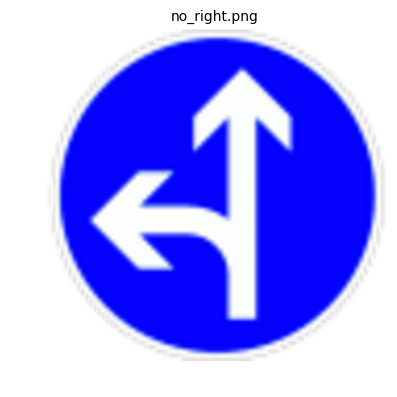

In [15]:
# Load external test images  which resemble the ones from database and plot
import os
import matplotlib.image as mpimg

DEBUG = 1

# Test Generator: get_next_test_data()
def get_next_test_data(foldername, files):
    for i,file in enumerate(files):
        img = mpimg.imread(foldername + "/" + file)
        if DEBUG:
            display(img, file)
        yield img
    plt.show()
    return None

def load_test_data(foldername):
    files = os.listdir(foldername)
    images = []
    for image in get_next_test_data(foldername, files):
        images.append(image)
    return images, files

TEST_DIR = './test-data/test-dataset-de'
ext_images, ext_files = load_test_data(TEST_DIR)

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
All the candidates mentioned above have been considered to analyze the network performance.
Following qualities of the images could make classification difficult: 

 ### Assuming generic images taken from anywhere:
1. They may not necessarily be in the training set
2. Unwanted data would result to incorrect inference. Input images should be cropped to contain only the traffic sign information
### For test images provided in the dataset:
1. Noise profile may affect inference if the network is not trained well
2. Valid data which do not match with training data. This has to do with network lacking generalization. Overfitting is one of the reasons network fail to generate correct inferences on test data inspite of being trained well
3. Non-affine projective transformations could make it difficult to classify signs. This means it would be difficult to classify a traffic sign image taken from a camera below the sign compared to the one taken from a camera in front of the sign


[14, 38, 31, 3, 27, 25, 29, 39, 36, 37]


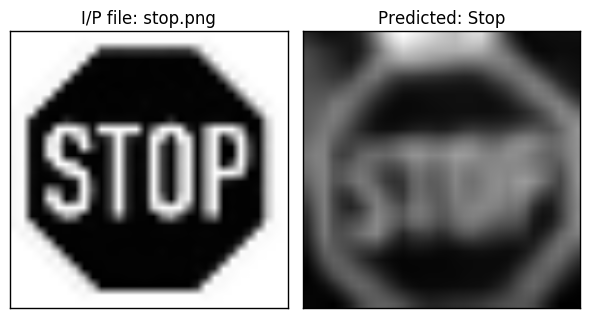

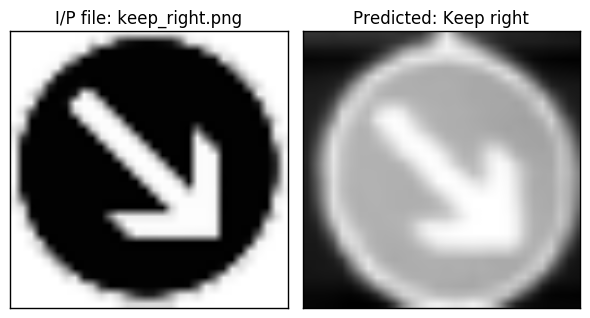

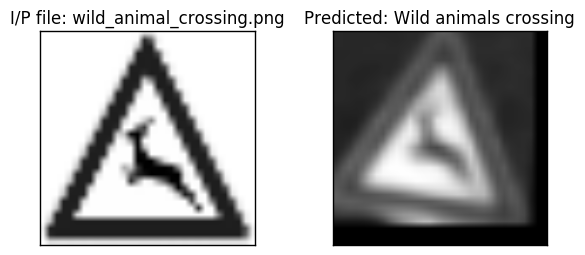

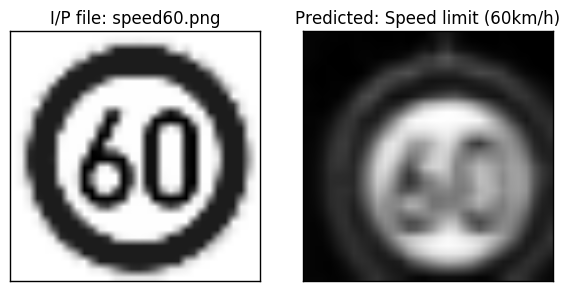

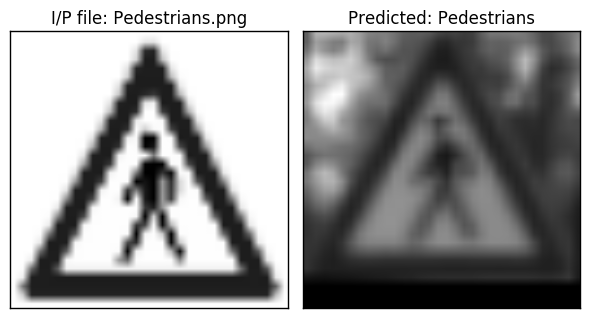

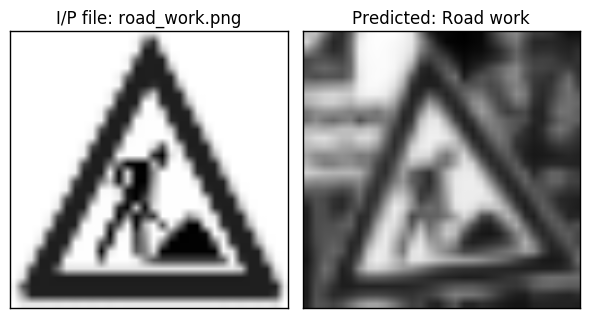

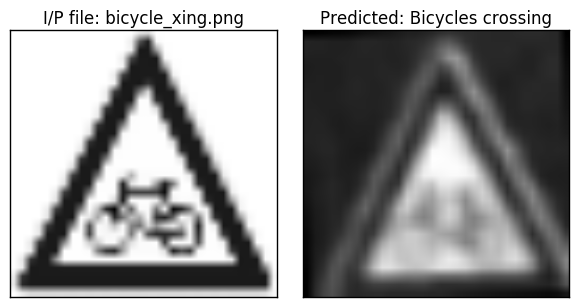

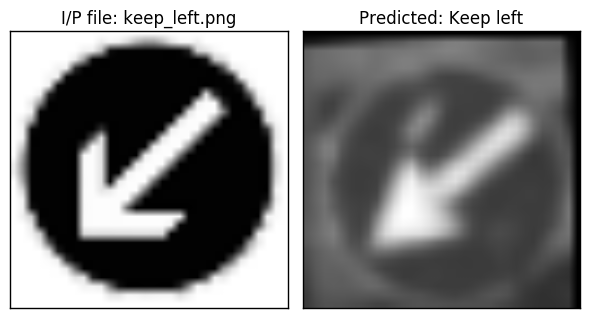

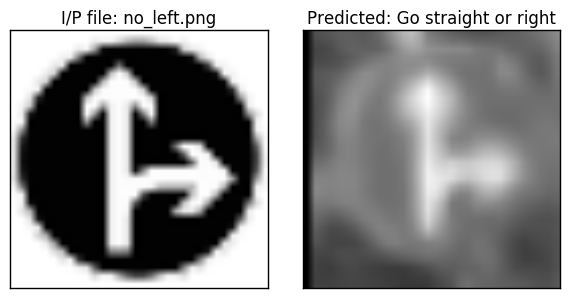

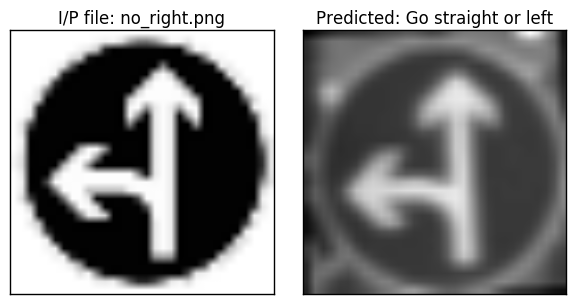

In [16]:
# Run predictions on loaded test data

ext_test_data = preprocess_list(ext_images, None, None)
DEBUG = 1
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    predictions, predict_prob = predict(ext_test_data)
    print (predictions)
    if DEBUG:
        for i, p_l in enumerate(predictions): 
            label1 = "I/P file: " + ext_files[i]
            label2 = "Predicted: " + str(sample_labels[p_l])
            display_comparison(ext_test_data[i], sample_images[p_l], label1, label2)

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

The network performs well on new images (from internet belonging to the dataset class).
1. Performance of the network is good (accuracy 100%)
2. The network has learned to generalize the signs well

In [17]:
correct_labels = [14, 38, 31, 3, 27, 25, 29, 39, 36, 37]

incorrect_detections = 0
for i, pred in enumerate(predictions):
    if pred != correct_labels[i]:
        incorrect_detections += 1
        
print ("External Test data incorrect Detections : %d/%d"%(incorrect_detections, len(predictions)))
print ("Accuracy : %.2f%%"%(100.0 - 100.0 * incorrect_detections/len(predictions)))

External Test data incorrect Detections : 0/10
Accuracy : 100.00%


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**
1. If only topmost probability considered for infering a traffic sign from the internet, the accuracy of the network was already high (100%)
    - Low probability here would mean the network is confused between multiple labels and they appear similar
    - We see that the probability with which the labels are detected is close to 1. This implies the network is pretty confident about the prediction
2. For test images from the dataset, accuracy of the network is around 89.78% 
3. With only top 5 probabilities included for test images the network accurary is as high as 95%
4. Infrastructure has been added however to check the probabilities and comment better about the accuracy and confidence/certainity of the network. If the network is certain the entry should be present in the first K (here 3) with high probability (say > 0.33) associated with the correct label

<b>Conclusion: </b> Accuracy of the network is better for high resolution images with lesser noise taken from the internet. We could consider the top 5 probabilites while removing the noise effect and building up the confidence if the network output is not stable due to changing lighting conditions or lack of training data. This should leading to less probable but consistent label inferencing from the network

In [18]:
with tf.Session() as sess:
    pred_ext, indices = sess.run(tf.nn.top_k(tf.constant(predict_prob), k=3))
    
for i,entry in enumerate(indices):
    print("--------------------")
    print("Image " + str(i) + " id: " + str(correct_labels[i]) + " [" + str(sample_labels[correct_labels[i]]) + "]")
    print("top K ")
    for j,idx in enumerate(entry):
        print ("        id: " + str(idx) + " [" + str(pred_ext[i][j]) + "]" + " [" + sample_labels[idx] + "]")

--------------------
Image 0 id: 14 [Stop]
top K 
        id: 14 [1.0] [Stop]
        id: 15 [1.49992e-17] [No vehicles]
        id: 9 [1.75146e-21] [No passing]
--------------------
Image 1 id: 38 [Keep right]
top K 
        id: 38 [1.0] [Keep right]
        id: 2 [2.69978e-37] [Speed limit (50km/h)]
        id: 0 [0.0] [Speed limit (20km/h)]
--------------------
Image 2 id: 31 [Wild animals crossing]
top K 
        id: 31 [1.0] [Wild animals crossing]
        id: 21 [1.11571e-35] [Double curve]
        id: 0 [0.0] [Speed limit (20km/h)]
--------------------
Image 3 id: 3 [Speed limit (60km/h)]
top K 
        id: 3 [1.0] [Speed limit (60km/h)]
        id: 0 [0.0] [Speed limit (20km/h)]
        id: 1 [0.0] [Speed limit (30km/h)]
--------------------
Image 4 id: 27 [Pedestrians]
top K 
        id: 27 [1.0] [Pedestrians]
        id: 11 [9.09887e-28] [Right-of-way at the next intersection]
        id: 24 [2.65289e-38] [Road narrows on the right]
--------------------
Image 5 id: 25 [Road w

In [19]:
correct_prediction_ext = tf.nn.in_top_k(predict_prob, correct_labels, k=3)
accuracy_op_ext = tf.reduce_mean(100*tf.cast(correct_prediction_ext, tf.int32))

with tf.Session() as sess:
    acc, valid_pred = sess.run([accuracy_op_ext, correct_prediction_ext])

print("Prediction Accuracy Internet images: %d%%" % acc)

Prediction Accuracy Internet images: 100%



## Appendix: Running random images grabbed from the internet through the network

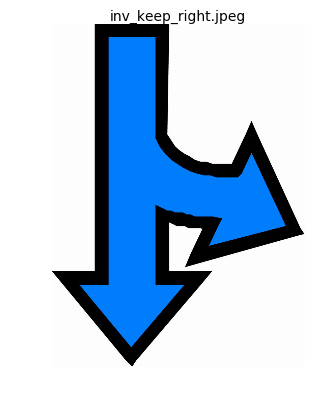

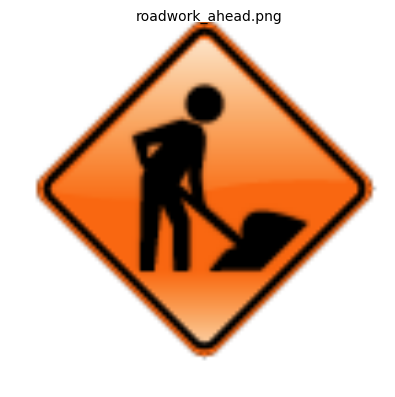

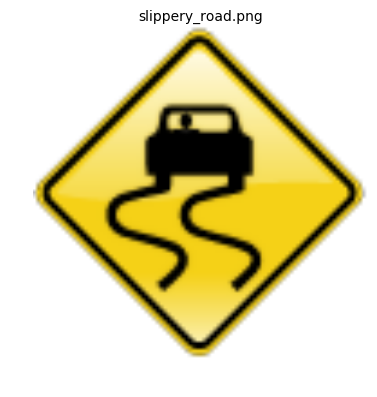

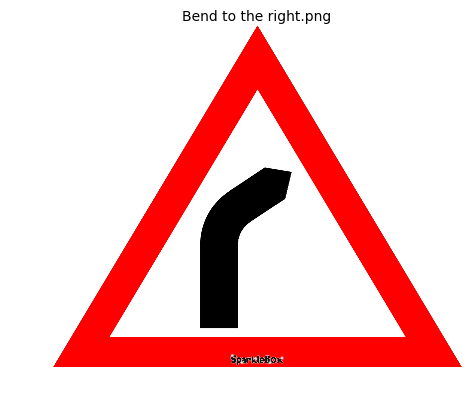

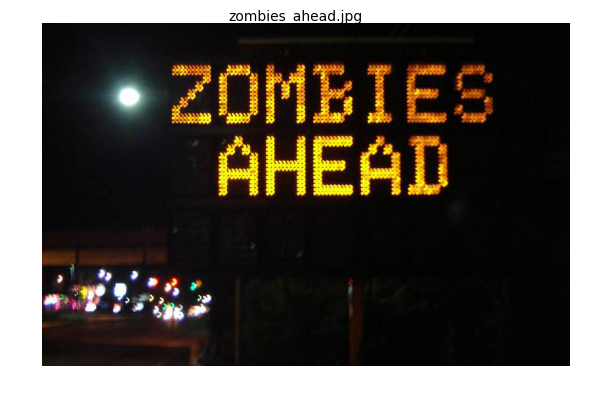

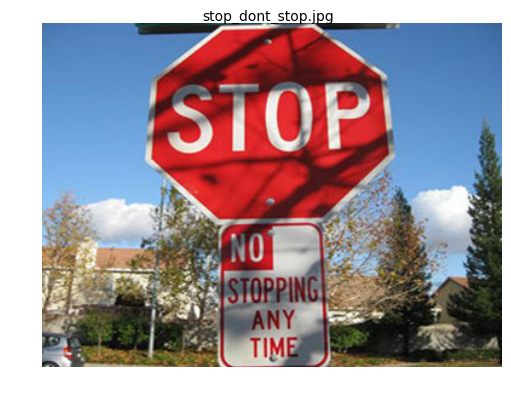

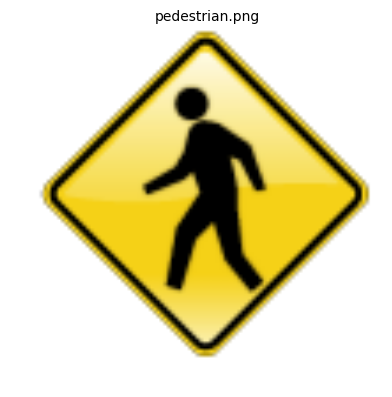

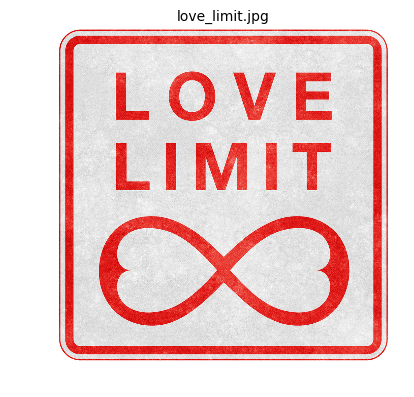

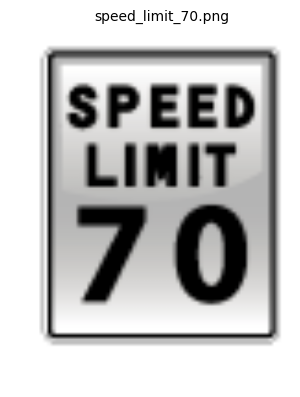

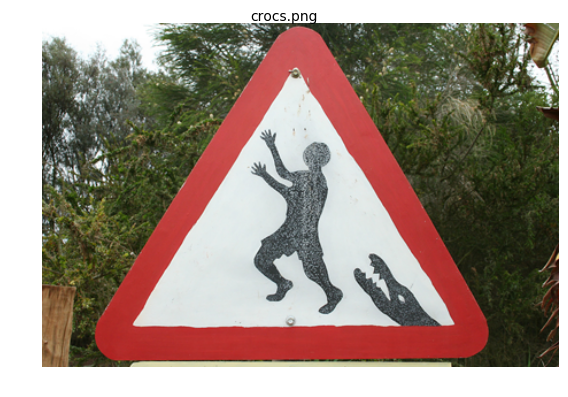

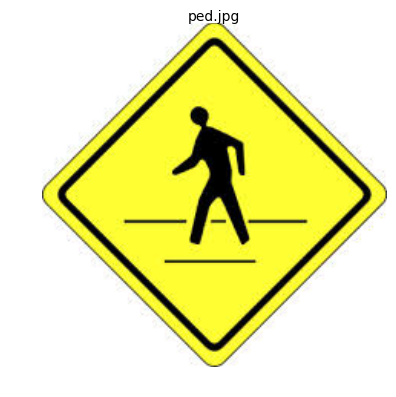

In [20]:
TEST_DIR = './test-data/test-dataset-random'
ext_images, ext_files = load_test_data(TEST_DIR)

[20, 34, 40, 11, 34, 40, 40, 40, 6, 26, 0]


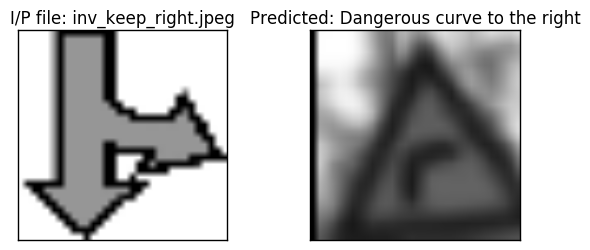

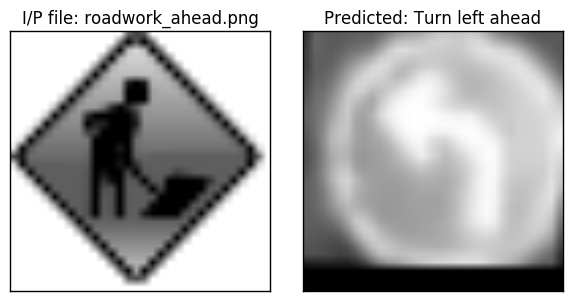

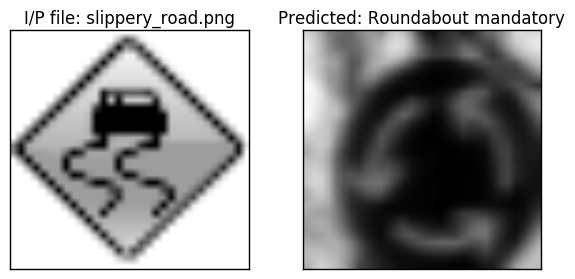

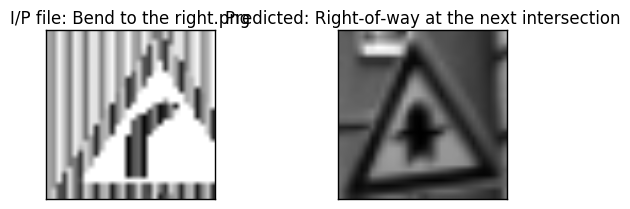

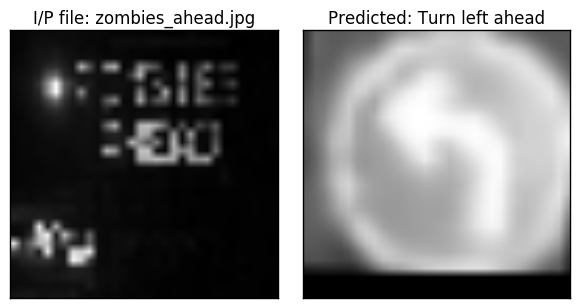

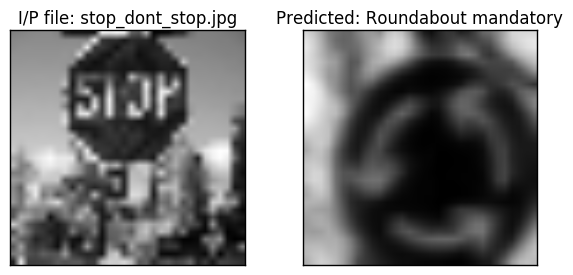

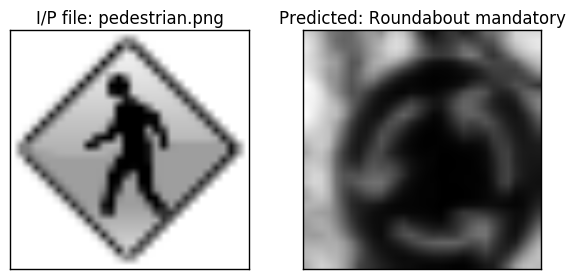

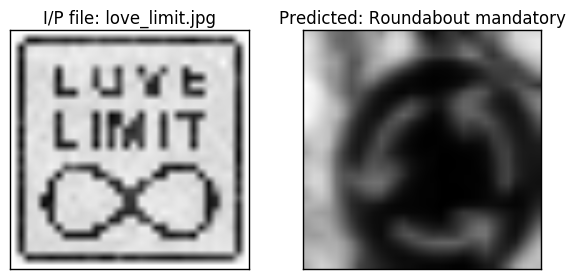

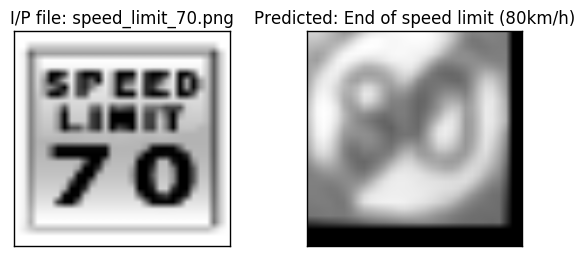

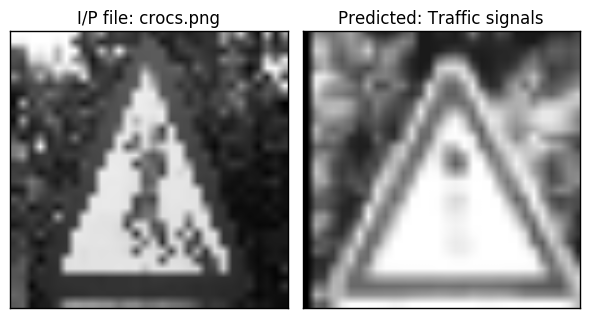

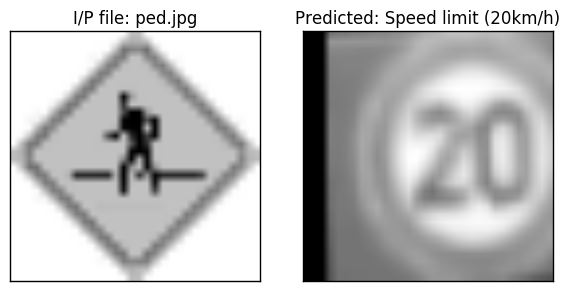

In [21]:
ext_test_data = preprocess_list(ext_images, None, None)
DEBUG = 1
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    predictions, predict_prob = predict(ext_test_data)
    print (predictions)
    if DEBUG:
        for i, p_l in enumerate(predictions): 
            label1 = "I/P file: " + ext_files[i]
            label2 = "Predicted: " + str(sample_labels[p_l])
            display_comparison(ext_test_data[i], sample_images[p_l], label1, label2)

<b>Some interesting Observations:</b>
1. The network does not behave quite well with random images taken from the internet
2. Crocodile threat appears to be a general traffic signal  (img: crocs.png)
3. In case there is roadwork ahead, the network in quest of adventure insists we go ahead on the same road at priority (img: roadwork_ahead.png)
4. It gets philosophical with love matters; in case you hit the love limit take a roundabout turn (img: love_limit.jpg)
5. Interesting to see that the network recommends users to take a left turn when it expects Zombies  ahead :D (img: zombies_ahead.jpg)
6. On a slippery road, round-about turn seems to be an adventurous recommendation too! (img: slippery_road.png)

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.